In [ ]:
!pip install openai langchain langchain-openai python-dotenv datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
import pandas as pd

#Loading the API Key
load_dotenv()
os.environ["OPENAI_API_KEY"] = "xxxx"

In [ ]:
from datasets import load_dataset

# Load full MMLU
ds = load_dataset("cais/mmlu", "all")

# Choose a specific subject subset for testing
df = ds["test"].filter(lambda x: x["subject"] == "high_school_biology").to_pandas()

# Rename for consistency
df = df.rename(columns={
    "question": "question",
    "choices": "choices",
    "answer": "correct_answer"
})

# Extract multiple choice options
df["A"] = df["choices"].apply(lambda x: x[0])
df["B"] = df["choices"].apply(lambda x: x[1])
df["C"] = df["choices"].apply(lambda x: x[2])
df["D"] = df["choices"].apply(lambda x: x[3])

df["correct_answer"] = df["correct_answer"].apply(lambda x: chr(ord("A") + int(x)))

df_sample = df.sample(10, random_state=42)


In [ ]:
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

# Use OpenAI GPT model
llm = ChatOpenAI(model="gpt-4o", temperature=0, max_tokens=1000)

# Define prompt template for multiple-choice QA
template = """
You are a biology expert. Use reasoning to solve each question.

Example 1:
Q: Which part of the cell contains DNA?
Choices:
A. Mitochondria
B. Cytoplasm
C. Nucleus
D. Ribosome
Answer: C

Example 2:
Q: Which gas is required for photosynthesis?
Choices:
A. Oxygen
B. Nitrogen
C. Carbon dioxide
D. Hydrogen
Answer: C

Now solve:
Q: {question}
Choices:
A. {A}
B. {B}
C. {C}
D. {D}
Answer:
"""

# Set up LangChain LLMChain
chain = LLMChain(llm=llm, prompt=prompt)


In [ ]:
def ask_agent(row):
    input_data = {
        "question": row["question"],
        "A": row["A"],
        "B": row["B"],
        "C": row["C"],
        "D": row["D"]
    }
    try:
        response = chain.invoke(input_data)
        full_answer = response["text"].strip()

        # Normalize to uppercase and remove punctuation
        answer_upper = full_answer.upper().replace(".", "").strip()

        # Try to match common patterns
        for choice in ["A", "B", "C", "D"]:
            if f"ANSWER IS {choice}" in answer_upper:
                return full_answer, choice
            elif answer_upper.endswith(f"{choice}"):
                return full_answer, choice
            elif answer_upper.strip() == choice:
                return full_answer, choice
        return full_answer, "?"
    except Exception as e:
        return f"Error: {e}", "?"


In [ ]:
df_sample[["agent_full_response", "agent_answer"]] = df_sample.apply(
    lambda row: pd.Series(ask_agent(row)),
    axis=1
)

df_sample["agent_answer_clean"] = df_sample["agent_answer"].apply(normalize_answer)
df_sample["is_correct"] = df_sample["agent_answer_clean"] == df_sample["correct_answer"]
accuracy = df_sample["is_correct"].mean()
print(f"✅ QA Agent Accuracy: {accuracy:.2%}")

✅ QA Agent Accuracy: 80.00%


In [ ]:
df_sample[["question", "A", "B", "C", "D", "correct_answer", "agent_answer", "agent_answer_clean", "is_correct"]]

,question,A,B,C,D,correct_answer,agent_answer,agent_answer_clean,is_correct
289,The end product of the alcohol fermentation pa...,Fermentation provides CO2 for photosynthesis.,Fermentation provides CO2 for cellular respira...,Yeast cells excrete ethanol in order to provid...,Fermentation replenishes the NAD+ necessary fo...,D,D,D,True
9,"In a hypothetical environment, fishes called p...",Selection for drab coloration of the algae-eaters,Selection for nocturnal algae-eaters (active o...,"Selection for larger female algae-eaters, bear...",Selection for algae-eaters that become sexuall...,C,C,C,True
57,"Catastrophism, meaning the regular occurrence ...",evolution.,the fossil record.,uniformitarianism.,the origin of new species.,B,B,B,True
60,Although mutations occur at a regular and pred...,Some mutations produce alleles that are recess...,Some undesirable phenotypic traits may be prev...,Some mutations cause such drastic phenotypic c...,The predictable rate of mutation results in on...,D,D,D,True
25,Which of the following statements best describ...,It is an inactivated Y chromosome and results ...,"It is an inactivated Y chromosome, and the per...",It is an inactivated X chromosome and results ...,It is an inactivated X chromosome and results ...,C,C,C,True
63,This biome contains plants whose roots cannot ...,Desert,Tundra,Taiga,Deciduous forests,C,B,B,False
92,Chemical substances released by organisms that...,auxins,hormones,pheromones,enzymes,C,C,C,True
184,"In a hypothetical population's gene pool, an a...",The proportions of both types of homozygote sh...,The proportion of the population that is heter...,The population's average heterozygosity should...,Both A and C,D,A,A,False
244,"Of the following anatomical structures, which ...",Dorsal fin of a shark,Hindlimb of a kangaroo,Wing of a butterfly,Flipper of a cetacean,D,D,D,True
46,Which statement about variation is true?,All phenotypic variation is the result of geno...,All genetic variation produces phenotypic vari...,All nucleotide variability results in neutral ...,All new alleles are the result of nucleotide v...,D,D,D,True


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('correct_answer').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('agent_answer').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('agent_answer_clean').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('is_correct').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['agent_answer'].value_counts()
    for x_label, grp in _df_4.groupby('correct_answer')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('correct_answer')
_ = plt.ylabel('agent_answer')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['agent_answer_clean'].value_counts()
    for x_label, grp in _df_5.groupby('agent_answer')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('agent_answer')
_ = plt.ylabel('agent_answer_clean')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['is_correct'].value_counts()
    for x_label, grp in _df_6.groupby('agent_answer_clean')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('agent_answer_clean')
_ = plt.ylabel('is_correct')

from matplotlib import pyplot as plt
_df_7['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_8.groupby('correct_answer').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_9.groupby('agent_answer').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_10.groupby('agent_answer_clean').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_11.groupby('is_correct').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_12['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['agent_answer'].value_counts()
    for x_label, grp in _df_13.groupby('correct_answer')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('correct_answer')
_ = plt.ylabel('agent_answer')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['agent_answer_clean'].value_counts()
    for x_label, grp in _df_14.groupby('agent_answer')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('agent_answer')
_ = plt.ylabel('agent_answer_clean')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['is_correct'].value_counts()
    for x_label, grp in _df_15.groupby('agent_answer_clean')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('agent_answer_clean')
_ = plt.ylabel('is_correct')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_16['correct_answer'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_16, x='index', y='correct_answer', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['agent_answer'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='index', y='agent_answer', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['agent_answer_clean'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='index', y='agent_answer_clean', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['is_correct'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='index', y='is_correct', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

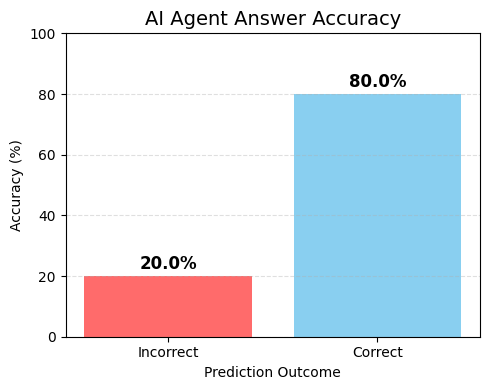

In [ ]:
import matplotlib.pyplot as plt

counts = df_sample["is_correct"].value_counts(normalize=True).sort_index()
labels = ["Incorrect", "Correct"]
percent_values = counts * 100

colors = ["#FF6B6B", "#89CFF0"]

# Plot
plt.figure(figsize=(5, 4))
bars = plt.bar(labels, percent_values, color=colors)

for bar, value in zip(bars, percent_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
             f"{value:.1f}%", ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title("AI Agent Answer Accuracy", fontsize=14)
plt.ylabel("Accuracy (%)")
plt.xlabel("Prediction Outcome")
plt.ylim(0, 100)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


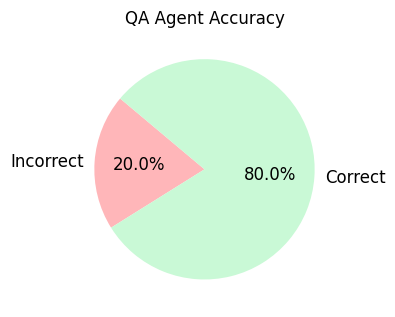

In [ ]:
plt.figure(figsize=(4, 4))
plt.pie(
    counts,
    labels=labels,
    autopct="%1.1f%%",
    colors=["#FFB6B9", "#C9F9D6"],
    startangle=140,
    textprops={'fontsize': 12}
)
plt.title("QA Agent Accuracy")
plt.tight_layout()
plt.show()


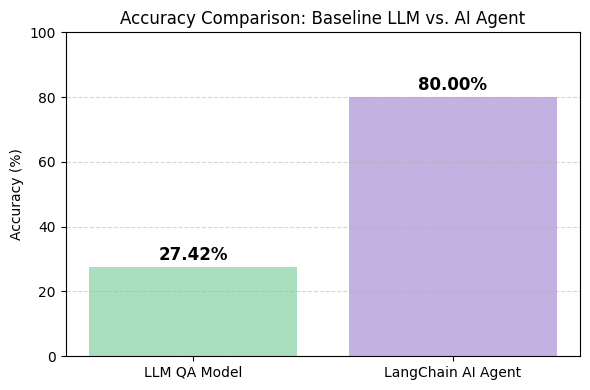

In [ ]:
import matplotlib.pyplot as plt

# Data
labels = ["LLM QA Model", "LangChain AI Agent"]
values = [27.42, 80.00]
colors = ["#A9DFBF", "#C3B1E1"]

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(labels, values, color=colors)

# Add value labels
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
             f"{value:.2f}%", ha='center', va='bottom', fontsize=12, fontweight='bold')

# Formatting
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Comparison: Baseline LLM vs. AI Agent")
plt.ylim(0, 100)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
#Generate the table of thoughts
def extract_reasoning(text):
    text = str(text).strip()
    split_keywords = ["the answer is", "answer:", "correct answer is", "final answer:"]

    for kw in split_keywords:
        if kw in text.lower():
            return text.split(kw)[0].strip()
    return text  # fallback: return full text

In [ ]:
df_sample["agent_reasoning"] = df_sample["agent_full_response"].apply(extract_reasoning)

In [ ]:
mistake_df = df_sample[df_sample["is_correct"] == False][[
    "question", "correct_answer", "agent_answer_clean", "agent_reasoning"
]]

mistake_df = mistake_df.rename(columns={
    "question": "Question",
    "correct_answer": "Correct Answer",
    "agent_answer_clean": "Agent's Answer",
    "agent_reasoning": "Agent's Thought Process"
})

mistake_df.head(10)

,Question,Correct Answer,Agent's Answer,Agent's Thought Process
63,This biome contains plants whose roots cannot ...,C,B,B
184,"In a hypothetical population's gene pool, an a...",D,A,A


In [ ]:
mistake_df.to_csv("qa_agent_error_analysis_table.csv", index=False)

In [ ]:
plt.savefig("Accuracy Comparison: Baseline LLM vs. AI Agent.png", dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [ ]:
from google.colab import files
files.download("Accuracy Comparison: Baseline LLM vs. AI Agent.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from datasets import load_dataset
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import torch

# Load dataset and filter for 'high_school_biology'
dataset = load_dataset("cais/mmlu", "all")
df_test = dataset["test"].to_pandas()
df_bio = df_test[df_test["subject"] == "high_school_biology"].reset_index(drop=True)

print(f"Loaded {len(df_bio)} biology questions.")


Loaded 310 biology questions.


In [ ]:
# Join choices into flat string
choices_text = df_bio["choices"].apply(lambda x: " ".join(x))

# Create vectorizer
vectorizer = CountVectorizer()
vectorizer.fit(df_bio["question"] + choices_text)

# Transform question and choices
question_vec = vectorizer.transform(df_bio["question"])
choices_vec = vectorizer.transform(choices_text)

# Convert to tensors
question_tensor = torch.tensor(question_vec.todense(), dtype=torch.float32)
choices_tensor = torch.tensor(choices_vec.todense(), dtype=torch.float32)

# Combine features
X_tensor = torch.cat((question_tensor, choices_tensor), dim=1)
y_tensor = torch.tensor(df_bio["answer"].astype(int).values, dtype=torch.long).unsqueeze(1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)

In [ ]:
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test_tensor.squeeze()).sum().item() / len(y_test_tensor)

print(f"Biology Test Accuracy: {accuracy:.2%}")

Biology Test Accuracy: 27.42%
